In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
! ls -l

In [ ]:
cd "/content/drive/MyDrive/project/"

In [ ]:
!ls

In [ ]:
os.getcwd()

In [ ]:
pip install --upgrade pip

In [ ]:
pip install tensorflow

In [ ]:
pip install tensorflow-gpu

In [ ]:
import keras

In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [ ]:
data_dir = 'pictures/validationData'

os.listdir(data_dir)

In [ ]:
data_dir = 'pictures/trainData'

os.listdir(data_dir)

In [ ]:
data_dir = 'pictures/test'

os.listdir(data_dir)

In [ ]:
SIZE = 128

train_images = []
train_labels = []
for directory_path in glob.glob("pictures/trainData/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# validation
validation_images = []
validation_labels = []
for directory_path in glob.glob("pictures/validationData/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        validation_images.append(img)
        validation_labels.append(fruit_label)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

In [ ]:
validation_images.shape

In [ ]:
# test
test_images = []
test_labels = []
for directory_path in glob.glob("pictures/test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
import sklearn
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(validation_labels)
validation_labels_encoded = le.transform(validation_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
#Split data into validation and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_validation, y_validation = train_images, train_labels_encoded, validation_images, validation_labels_encoded
# Normalize pixel values to between 0 and 1
x_train, x_validation = x_train / 255.0, x_validation / 255.0

# testing
x_test = test_images
x_test = x_test / 255.0

In [ ]:
#One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_validation_one_hot = to_categorical(y_validation)

In [ ]:
activation = 'relu'

#feature_extractor instead of model
feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [ ]:
#Add layers for deep learning prediction
x = feature_extractor.output
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)
#because of 4 classes

In [ ]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

In [ ]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
tf.__version__

In [ ]:
#Train the CNN model
## checkpointing
checkpoint_path = "models_saved/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

In [ ]:
history = cnn_model.fit(x_train, y_train_one_hot, epochs=40, validation_data = (x_validation, y_validation_one_hot),callbacks=[cp_callback])

In [ ]:
#Saving entire model
cnn_model.save('models_saved/GPU_model2.h5')

In [ ]:
from keras.models import load_model
new_model = load_model('models_saved/GPU_model2.h5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
prediction_NN = cnn_model.predict(x_validation)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
n=150  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])


In [ ]:
!pip install tf-nightly scipy

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)

In [ ]:
tflite_model = converter.convert()

with open("model2.tflite", 'wb') as f:
    f.write(tflite_model)

Random Forest (Extra Work; Trying out)

In [ ]:
# Using features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 0)

In [ ]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

In [ ]:
#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_validation)

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

In [ ]:
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(validation_labels, prediction_RF))

In [ ]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(validation_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
#Check results on a few select images
#n=5 #dog park. RF works better than CNN
n=9 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

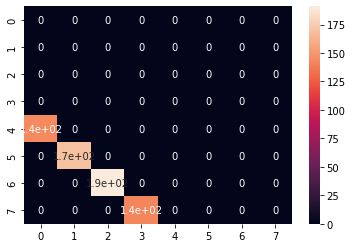

In [72]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(validation_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 43ms/step
The prediction for this image is:  ['pictures/trainData/over_ripe']
The actual label for this image is:  pictures/test/over_ripe


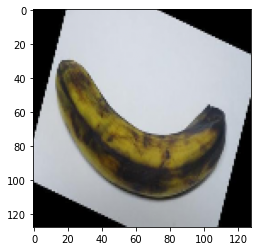

In [73]:
#Check results on a few select images
#n=5 #dog park. RF works better than CNN
n=9 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])